# 训练 OCR 文本内容识别模型：Kaggle CAPTCHA 验证码文本识别分类

下载数据科学竞赛网站 Kaggle [CAPTCHA 验证码文本识别分类数据集](https://www.kaggle.com/datasets/fournierp/captcha-version-2-images/)，划分训练集、测试集，整理数据、标签。

使用 MMOCR 训练基于 SAR 的文本内容识别模型。

并在测试集上评估模型性能。

## 切换工作目录到主目录

In [1]:
import os
os.chdir('mmocr')
os.listdir()

['.git',
 '.circleci',
 '.codespellrc',
 '.coveragerc',
 '.github',
 '.gitignore',
 '.owners.yml',
 '.pre-commit-config.yaml',
 '.pylintrc',
 '.readthedocs.yml',
 'CITATION.cff',
 'LICENSE',
 'MANIFEST.in',
 'README.md',
 'README_zh-CN.md',
 'configs',
 'demo',
 'docker',
 'docs',
 'mmocr',
 'model-index.yml',
 'requirements.txt',
 'requirements',
 'resources',
 'setup.cfg',
 'setup.py',
 'tests',
 'tools',
 'mmocr.egg-info',
 'outputs',
 'data',
 'font.TTF',
 'INFO']

## 导入工具包

In [2]:
# 导入 opencv-python
import cv2

# 导入可视化工具包 matplotlib，并让绘制的图像嵌入在 notebook 中
import matplotlib.pyplot as plt
%matplotlib inline

# 定义可视化图像函数，输入图像路径，可视化图像
def show_img_from_path(img_path):
    '''opencv 读入图像，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来'''
    img = cv2.imread(img_path)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()
    
# 定义可视化图像函数，输入图像 array，可视化图像
def show_img_from_array(img):
    '''输入 array，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来'''
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()

## 验证码数据集

In [3]:
# 删除原有的 ocr_toy_dataset 目录
!rm -rf tests/data/ocr_toy_dataset

# 创建一个新的 ocr_toy_dataset 空文件夹
!mkdir tests/data/ocr_toy_dataset
!mkdir tests/data/ocr_toy_dataset/imgs

访问数据集主页

https://www.kaggle.com/datasets/fournierp/captcha-version-2-images/

将下载得到的 archive.zip 解压，得到samples文件夹，将其中的所有图像文件(1070张 .png 文件) 上传至 tests/data/ocr_toy_dataset/imgs

## 划分训练集和测试集，生成标签文件

In [4]:
import pandas as pd
print('imgs文件夹中的文件总数', len(os.listdir('tests/data/ocr_toy_dataset/imgs')))
df = pd.DataFrame()
# 获取所有图像的文件名
df['file_name'] = os.listdir('tests/data/ocr_toy_dataset/imgs')
# 由文件名提取文本内容标签
df['label'] = df['file_name'].apply(lambda x:x.split('.')[0])
# 随机打乱
df = df.sample(frac=1)
# 重排索引
df.reset_index(drop=True, inplace=True)

# 训练集
train_df = df.iloc[:800]
# 测试集
test_df = df.iloc[801:]

# 生成训练集标签
train_df.to_csv('tests/data/ocr_toy_dataset/train_label.txt', sep=' ', index=False, header=None)
# 生成测试集标签
test_df.to_csv('tests/data/ocr_toy_dataset/test_label.txt', sep=' ', index=False, header=None)
print('标签文件生成成功！')

imgs文件夹中的文件总数 1070
标签文件生成成功！


训练集图像路径和标签：train_label.txt

测试集图像路径和标签：test_label.txt

In [ ]:
'''
数据集目录结构


└── tests
     └── data
           └── ocr_toy_dataset
                ├── train_label.txt
                ├── test_label.txt
                └── imgs
                      ├── 226md.png
                      ├── 22d5n.png
                          ......
'''

## 查看数据集中的图像

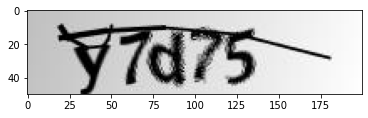

In [5]:
show_img_from_path('tests/data/ocr_toy_dataset/imgs/y7d75.png')

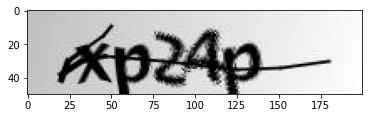

In [6]:
show_img_from_path('tests/data/ocr_toy_dataset/imgs/xp24p.png')

In [7]:
# 查看标注文件
!cat tests/data/ocr_toy_dataset/train_label.txt | head -n 10

w2yp7.png w2yp7
gwnm6.png gwnm6
5bb66.png 5bb66
5pm6b.png 5pm6b
ffd6p.png ffd6p
b3xpn.png b3xpn
c482b.png c482b
mddgb.png mddgb
nngxc.png nngxc
c3572.png c3572


## 修改训练配置 config 文件

In [8]:
# 删除原有的 configs/_base_/recog_datasets/toy_data.py 文件
!rm configs/_base_/recog_datasets/toy_data.py

In [9]:
# 下载新的 toy_data.py 文件，覆盖被删除的文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220323-mmocr/toy_data.py -O configs/_base_/recog_datasets/toy_data.py

--2022-03-25 17:39:01--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220323-mmocr/toy_data.py
Connecting to 172.16.0.13:5848... connected.
Proxy request sent, awaiting response... 200 OK
Length: 954 [binary/octet-stream]
Saving to: ‘configs/_base_/recog_datasets/toy_data.py’

configs/_base_/reco 100%[===================>]     954  --.-KB/s    in 0s      

2022-03-25 17:39:06 (42.5 MB/s) - ‘configs/_base_/recog_datasets/toy_data.py’ saved [954/954]



In [10]:
!cat configs/_base_/recog_datasets/toy_data.py

dataset_type = 'OCRDataset'

root = 'tests/data/ocr_toy_dataset'
img_prefix = f'{root}/imgs'
train_anno_file1 = f'{root}/train_label.txt'

train1 = dict(
    type=dataset_type,
    img_prefix=img_prefix,
    ann_file=train_anno_file1,
    loader=dict(
        type='HardDiskLoader',
        repeat=10, # 与训练轮次相关
        parser=dict(
            type='LineStrParser',
            keys=['filename', 'text'],
            keys_idx=[0, 1],
            separator=' ')),
    pipeline=None,
    test_mode=False)

test_anno_file1 = f'{root}/test_label.txt'
test = dict(
    type=dataset_type,
    img_prefix=img_prefix,
    ann_file=test_anno_file1,
    loader=dict(
        type='HardDiskLoader',
        repeat=1,
        parser=dict(
            type='LineStrParser',
            keys=['filename', 'text'],
            keys_idx=[0, 1],
            separator=' ')),
    pipeline=None,
    test_mode=True)

train_list = [train1]

test_list = [test]

In [11]:
from mmcv import Config
cfg = Config.fromfile('./configs/textrecog/sar/sar_r31_parallel_decoder_toy_dataset.py')

In [12]:
from mmdet.apis import set_random_seed

# 存放输出结果和日志的目录
cfg.work_dir = './demo/tutorial_exps'

# 初始学习率 0.001 是针对 8 个 GPU 训练的
# 如果只有一个 GPU，则除以8
cfg.optimizer.lr = 0.001 / 8
cfg.lr_config.warmup = None

# 每训练 500 张图像，记录一次日志
cfg.log_config.interval = 500

# 设置随机数种子
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# 总共训练多少个 epoch
# cfg.total_epochs = 15
# 每训练多少个 epoch 评估一次模型性能
# cfg.evaluation.interval = 10
# # 每训练多少个 epoch 保存一次模型
# cfg.checkpoint_config.interval = 10

查看最终的训练配置 config 文件

In [13]:
print(cfg.pretty_text)

checkpoint_config = dict(interval=1)
log_config = dict(interval=500, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
label_convertor = dict(
    type='AttnConvertor', dict_type='DICT90', with_unknown=True)
model = dict(
    type='SARNet',
    backbone=dict(type='ResNet31OCR'),
    encoder=dict(
        type='SAREncoder', enc_bi_rnn=False, enc_do_rnn=0.1, enc_gru=False),
    decoder=dict(
        type='ParallelSARDecoder',
        enc_bi_rnn=False,
        dec_bi_rnn=False,
        dec_do_rnn=0,
        dec_gru=False,
        pred_dropout=0.1,
        d_k=512,
        pred_concat=True),
    loss=dict(type='SARLoss'),
    label_convertor=dict(
        type='AttnConvertor', dict_type='DICT90', with_unknown=True),
    max_seq_len=30)
optimizer = dict(type='Adam', lr=0.000125)
optimizer_config = dict(grad_clip=None)
lr_config = dict(policy=

## 准备训练

In [14]:
import mmcv
from mmocr.datasets import build_dataset
from mmocr.models import build_detector
from mmocr.apis import train_detector
import os.path as osp

/environment/miniconda3/lib/python3.7/site-packages/mmdet/datasets/pipelines/formating.py:7: UserWarning: DeprecationWarning: mmdet.datasets.pipelines.formating will be deprecated, please replace it with mmdet.datasets.pipelines.formatting.
  warnings.warn('DeprecationWarning: mmdet.datasets.pipelines.formating will be '


In [15]:
# 建立数据集
datasets = [build_dataset(cfg.data.train)]

/home/featurize/work/MMOCR教程/0325/mmocr/mmocr/datasets/utils/loader.py:86: UserWarning: HardDiskLoader is deprecated, please use AnnFileLoader instead.
  'AnnFileLoader instead.', UserWarning)


In [16]:
# 建立模型
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# 创建新目录，保存训练结果
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

## 训练模型（大概需要五分钟）

如果报错 CUDA out of memory，则说明显存不足，把之前几个 notebook 的kernel关闭，释放显存即可。

In [17]:
train_detector(model, datasets, cfg, distributed=False, validate=True)

/home/featurize/work/MMOCR教程/0325/mmocr/mmocr/apis/train.py:86: UserWarning: config is now expected to have a `runner` section, please set `runner` in your config.
  'please set `runner` in your config.', UserWarning)
/home/featurize/work/MMOCR教程/0325/mmocr/mmocr/apis/utils.py:53: UserWarning: Remove "MultiRotateAugOCR" to support batch inference since samples_per_gpu > 1.
  warnings.warn(warning_msg)
/home/featurize/work/MMOCR教程/0325/mmocr/mmocr/datasets/utils/loader.py:86: UserWarning: HardDiskLoader is deprecated, please use AnnFileLoader instead.
  'AnnFileLoader instead.', UserWarning)
2022-03-25 17:39:58,547 - mmocr - INFO - Start running, host: featurize@featurize, work_dir: /home/featurize/work/MMOCR教程/0325/mmocr/demo/tutorial_exps
2022-03-25 17:39:58,548 - mmocr - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                         

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 269/269, 63.1 task/s, elapsed: 4s, ETA:     0s

2022-03-25 17:41:24,482 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/test_label.txt with 269 images now
2022-03-25 17:41:24,494 - mmocr - INFO - Epoch(val) [1][34]	0_word_acc: 0.9926, 0_word_acc_ignore_case: 0.9926, 0_word_acc_ignore_case_symbol: 0.9926, 0_char_recall: 0.9985, 0_char_precision: 0.9985, 0_1-N.E.D: 0.9985
2022-03-25 17:42:00,677 - mmocr - INFO - Epoch [2][500/1000]	lr: 1.250e-04, eta: 0:04:05, time: 0.072, data_time: 0.008, memory: 1783, loss_ce: 0.2609, loss: 0.2609
2022-03-25 17:42:34,074 - mmocr - INFO - Epoch [2][1000/1000]	lr: 1.250e-04, eta: 0:03:27, time: 0.067, data_time: 0.003, memory: 1783, loss_ce: 0.2527, loss: 0.2527
2022-03-25 17:42:34,432 - mmocr - INFO - Saving checkpoint at 2 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 269/269, 63.7 task/s, elapsed: 4s, ETA:     0s

2022-03-25 17:42:43,494 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/test_label.txt with 269 images now
2022-03-25 17:42:43,505 - mmocr - INFO - Epoch(val) [2][34]	0_word_acc: 0.9926, 0_word_acc_ignore_case: 0.9926, 0_word_acc_ignore_case_symbol: 0.9926, 0_char_recall: 0.9985, 0_char_precision: 0.9985, 0_1-N.E.D: 0.9985
2022-03-25 17:43:18,608 - mmocr - INFO - Epoch [3][500/1000]	lr: 1.250e-04, eta: 0:02:53, time: 0.070, data_time: 0.006, memory: 1783, loss_ce: 0.2284, loss: 0.2284
2022-03-25 17:43:51,675 - mmocr - INFO - Epoch [3][1000/1000]	lr: 1.250e-04, eta: 0:02:17, time: 0.066, data_time: 0.002, memory: 1783, loss_ce: 0.2266, loss: 0.2266
2022-03-25 17:43:52,263 - mmocr - INFO - Saving checkpoint at 3 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 269/269, 62.5 task/s, elapsed: 4s, ETA:     0s

2022-03-25 17:44:03,791 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/test_label.txt with 269 images now
2022-03-25 17:44:03,799 - mmocr - INFO - Epoch(val) [3][34]	0_word_acc: 0.9926, 0_word_acc_ignore_case: 0.9926, 0_word_acc_ignore_case_symbol: 0.9926, 0_char_recall: 0.9985, 0_char_precision: 0.9985, 0_1-N.E.D: 0.9985
2022-03-25 17:44:39,379 - mmocr - INFO - Epoch [4][500/1000]	lr: 1.250e-05, eta: 0:01:43, time: 0.071, data_time: 0.006, memory: 1783, loss_ce: 0.2340, loss: 0.2340
2022-03-25 17:45:12,760 - mmocr - INFO - Epoch [4][1000/1000]	lr: 1.250e-05, eta: 0:01:08, time: 0.067, data_time: 0.002, memory: 1783, loss_ce: 0.2239, loss: 0.2239
2022-03-25 17:45:12,842 - mmocr - INFO - Saving checkpoint at 4 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 269/269, 62.4 task/s, elapsed: 4s, ETA:     0s

2022-03-25 17:45:20,824 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/test_label.txt with 269 images now
2022-03-25 17:45:20,835 - mmocr - INFO - Epoch(val) [4][34]	0_word_acc: 0.9926, 0_word_acc_ignore_case: 0.9926, 0_word_acc_ignore_case_symbol: 0.9926, 0_char_recall: 0.9985, 0_char_precision: 0.9985, 0_1-N.E.D: 0.9985
2022-03-25 17:45:56,262 - mmocr - INFO - Epoch [5][500/1000]	lr: 1.250e-06, eta: 0:00:34, time: 0.071, data_time: 0.006, memory: 1783, loss_ce: 0.2285, loss: 0.2285
2022-03-25 17:46:29,648 - mmocr - INFO - Epoch [5][1000/1000]	lr: 1.250e-06, eta: 0:00:00, time: 0.067, data_time: 0.002, memory: 1783, loss_ce: 0.2312, loss: 0.2312
2022-03-25 17:46:29,717 - mmocr - INFO - Saving checkpoint at 5 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 269/269, 62.3 task/s, elapsed: 4s, ETA:     0s

2022-03-25 17:46:36,358 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/test_label.txt with 269 images now
2022-03-25 17:46:36,365 - mmocr - INFO - Epoch(val) [5][34]	0_word_acc: 0.9926, 0_word_acc_ignore_case: 0.9926, 0_word_acc_ignore_case_symbol: 0.9926, 0_char_recall: 0.9985, 0_char_precision: 0.9985, 0_1-N.E.D: 0.9985


## OCR 模型性能评估指标

详见`mmocr/core/evaluation/ocr_metric.py`

## 用刚刚训练得到的模型，在测试图片上预测

使用最新的模型 checkpoint，用 hmean-iou 指标，预测结果存储在`./outputs`

In [18]:
from mmocr.apis import init_detector, model_inference

In [19]:
# 指定模型 checkpoint 权重文件
checkpoint = "./demo/tutorial_exps/epoch_5.pth"

model = init_detector(cfg, checkpoint, device="cuda:0")

load checkpoint from local path: ./demo/tutorial_exps/epoch_5.pth


/home/featurize/work/MMOCR教程/0325/mmocr/mmocr/apis/inference.py:50: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [20]:
# 查看标注文件
!cat tests/data/ocr_toy_dataset/test_label.txt | head -n 10

ffnxn.png ffnxn
g888x.png g888x
pyf65.png pyf65
7y2x4.png 7y2x4
pdyc8.png pdyc8
nnn57.png nnn57
c86md.png c86md
cwmny.png cwmny
6n443.png 6n443
75pfw.png 75pfw


In [21]:
input_path = 'tests/data/ocr_toy_dataset/imgs/658xe.png'

In [22]:
result = model_inference(model, input_path)

In [23]:
result

{'text': '658xe', 'score': 0.9999989986419677}

In [24]:
out_img = model.show_result(input_path, result, out_file='outputs/demo-out.jpg', show=False)

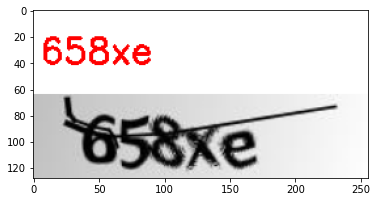

In [25]:
show_img_from_array(out_img)